In [55]:
#import nltk # please download wordnet and stopwords if not already downloaded 

import nltk # please download wordnet and stopwords if not already downloaded 

import pandas as pd
import numpy as np

from nltk.corpus import wordnet
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

from matplotlib import pyplot as plt 
from pylab import xticks
import numpy as np
import matplotlib.ticker as ticker
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score
import pickle
import time

In [56]:
df=pd.read_csv('japan_armrvr_final2.csv')

In [57]:
df.columns

Index(['patnum', 'clustered_patnum', 'country_code', 'stripped_patnum',
       'pat_id', 'title', 'abstract', 'final_category'],
      dtype='object')

In [58]:
df['final_category_labels']=le.fit_transform(df.final_category)

In [59]:
def g(row):
    
    if row['final_category']=='Haptics':
        
        val=1
    
    else:
        val=0
    
    
    return val

df['labels']=df.apply(g,axis=1)

In [60]:
p=pd.DataFrame()
p['encoding']=df.final_category_labels.unique()
p['labels']=le.inverse_transform(df.final_category_labels.unique())
p.sort_values(['encoding'])

,encoding,labels
6,0,Advertising
12,1,Audio
9,2,Authentication
8,3,Battery
2,4,Eye Tracking
3,5,Fitness/Health
4,6,Gaming
0,7,Gesture/Motion Tracking
5,8,Haptics
7,9,Location based services


In [61]:
df['all_text']=df['title'].map(str)+' '+df['abstract'].map(str)

In [62]:
# # #Using regex to clean the incoming corpus 

# #df=pd.read_csv('all_claims_with_direction.csv',index_col=0)


# # df=pd.read_csv('/Users/ssaeed/Documents/all_claims_edited_0204.csv',encoding='latin1')

# import re

# def split_it(line):
    
#     line2=re.sub('\b\w{1,3}\b|<.*?>|((\d+)[\.])|\((.+?)\)|[0-9]+',"",str(line))
    
#     return line2

# df['all_text']=df['all_text'].apply(split_it)

# df.drop_duplicates(subset=None, keep='first', inplace=False)

In [63]:
#Stemming and Lemmatization

stemmer = SnowballStemmer("english", ignore_stopwords=True)
lemmer=LancasterStemmer()
lemma=WordNetLemmatizer()


class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: ([lemma.lemmatize(w) for w in analyzer(doc)]) 

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

SCV = StemmedCountVectorizer(ngram_range=(1,2),stop_words='english',max_df=0.2,min_df=2)

LCV=LemmaCountVectorizer(stop_words='english',ngram_range=(1,2),max_features=4000,max_df=0.2,min_df=3)

In [105]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
#claim_tr, claim_tst, label_tr, label_tst = train_test_split(claims, labels, test_size = 0.2, random_state = 0)

train,test = train_test_split(df,test_size = 0.4, random_state = 0)


# Show the results of the split
print ("Training set has {} samples.".format(train.shape[0]))
print ("Testing set has {} samples.".format(test.shape[0]))

Training set has 26187 samples.
Testing set has 17458 samples.


In [106]:
print(train.labels.sum(),test.labels.sum())

820 548


In [107]:
from sklearn.utils import resample

nhap=test[test.labels==0]
hap=test[test.labels==1]

hap=resample(hap,replace=True,n_samples=len(nhap),random_state=12)

full=pd.concat([hap,nhap])

claim_tst=full['all_text']
label_tst=full['labels']

nhap=train[train.labels==0]
hap=train[train.labels==1]

hap=resample(hap,replace=True,n_samples=len(nhap),random_state=12)

full=pd.concat([hap,nhap])

claim_tr=full['all_text']
label_tr=full['labels']

In [67]:
# claim_tr=train['all_text']
# label_tr=train['labels']
# claim_tst=test['all_text']
# label_tst=test['labels']

In [68]:
import re

def words_and_char_bigrams(text):
    words = re.findall(r'\w{4,18}', text)
    for w in words:
        yield w.lower()

LCV=LemmaCountVectorizer(stop_words='english',ngram_range=(1,2),max_df=0.6,min_df=3,max_features=8000)


#transformer = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True))])

text_ensemble_lemmatized = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True)),
                                     ('lr',LogisticRegression(C=0.015,penalty='l2',class_weight={0:1,1:1}))])

text_ensemble_lemmatized.fit(claim_tr,label_tr)
predicted=text_ensemble_lemmatized.predict(claim_tst)
#predicted2=text_ensemble_lemmatized.predict(claim)
#predicted3=text_ensemble_lemmatized.predict_proba(claims)[:,1]
predicted4=text_ensemble_lemmatized.predict_proba(claim_tst)[:,1]
predicted6=text_ensemble_lemmatized.predict_proba(claim_tst)

from sklearn.metrics import f1_score,precision_score,recall_score

print("F1:",round(f1_score(label_tst,predicted,average='binary'),3))
print("Precision:",round(precision_score(label_tst,predicted,average='binary'),3))
print("Recall:",round(recall_score(label_tst,predicted,average='binary'),3))
print("ROC SCORE=",round(roc_auc_score(label_tst,predicted4),3))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1: 0.946
Precision: 0.961
Recall: 0.932
ROC SCORE= 0.984


In [69]:
# %%time 

# import re

# def words_and_char_bigrams(text):
#     words = re.findall(r'\w{4,18}', text)
#     for w in words:
#         yield w.lower()

# LCV=LemmaCountVectorizer(stop_words='english',ngram_range=(1,3),max_df=0.8,min_df=3,max_features=4000)


# #transformer = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True))])

# text_ensemble_lemmatized = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True)),
#                                      ('lr',LogisticRegression(C=0.6,penalty='l2',class_weight={0:1,1:1}))])

# text_ensemble_lemmatized.fit(claim_tr,label_tr)
# predicted=text_ensemble_lemmatized.predict(claim_tst)
# #predicted2=text_ensemble_lemmatized.predict(claim)
# #predicted3=text_ensemble_lemmatized.predict_proba(claims)[:,1]
# predicted4=text_ensemble_lemmatized.predict_proba(claim_tst)[:,1]
# predicted6=text_ensemble_lemmatized.predict_proba(claim_tst)

# from sklearn.metrics import f1_score,precision_score,recall_score

# print("F1:",round(f1_score(label_tst,predicted,average='binary'),3))
# print("Precision:",round(precision_score(label_tst,predicted,average='binary'),3))
# print("Recall:",round(recall_score(label_tst,predicted,average='binary'),3))
# print("ROC SCORE=",round(roc_auc_score(label_tst,predicted4),3))

In [70]:
import re

def words_and_char_bigrams(text):
    words = re.findall(r'\w{4,18}', text)
    for w in words:
        yield w.lower()

LCV=LemmaCountVectorizer(stop_words='english',ngram_range=(1,2),max_df=0.6,min_df=3,max_features=8000)


#transformer = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True))])

text_ensemble_lemmatized = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True)),
                                     ('lr',LogisticRegression(C=0.4,penalty='l2',class_weight={0:1,1:3}))])

text_ensemble_lemmatized.fit(claim_tr,label_tr)
predicted=text_ensemble_lemmatized.predict(claim_tst)
#predicted2=text_ensemble_lemmatized.predict(claim)
#predicted3=text_ensemble_lemmatized.predict_proba(claims)[:,1]
predicted4=text_ensemble_lemmatized.predict_proba(claim_tst)[:,1]
predicted6=text_ensemble_lemmatized.predict_proba(claim_tst)

from sklearn.metrics import f1_score,precision_score,recall_score

print("F1:",round(f1_score(label_tst,predicted,average='binary'),3))
print("Precision:",round(precision_score(label_tst,predicted,average='binary'),3))
print("Recall:",round(recall_score(label_tst,predicted,average='binary'),3))
print("ROC SCORE=",round(roc_auc_score(label_tst,predicted4),3))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1: 0.95
Precision: 0.964
Recall: 0.935
ROC SCORE= 0.988


In [108]:
import re

def words_and_char_bigrams(text):
    words = re.findall(r'\w{4,18}', text)
    for w in words:
        yield w.lower()

LCV=LemmaCountVectorizer(stop_words='english',ngram_range=(1,2),max_df=0.5,min_df=3,max_features=8000)


#transformer = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True))])

text_ensemble_lemmatized = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True)),
                                     ('lr',LogisticRegression(C=0.8,penalty='l2',class_weight={0:1,1:1.6}))])

text_ensemble_lemmatized.fit(claim_tr,label_tr)
predicted=text_ensemble_lemmatized.predict(claim_tst)
#predicted2=text_ensemble_lemmatized.predict(claim)
#predicted3=text_ensemble_lemmatized.predict_proba(claims)[:,1]
predicted4=text_ensemble_lemmatized.predict_proba(claim_tst)[:,1]
predicted6=text_ensemble_lemmatized.predict_proba(claim_tst)

from sklearn.metrics import f1_score,precision_score,recall_score

print("F1:",round(f1_score(label_tst,predicted,average='binary'),3))
print("Precision:",round(precision_score(label_tst,predicted,average='binary'),3))
print("Recall:",round(recall_score(label_tst,predicted,average='binary'),3))
print("ROC SCORE=",round(roc_auc_score(label_tst,predicted4),3))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1: 0.942
Precision: 0.977
Recall: 0.91
ROC SCORE= 0.988


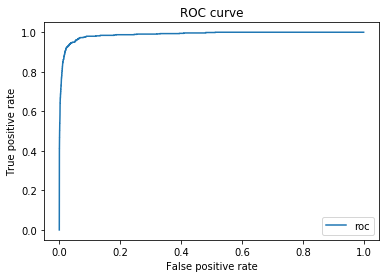

In [109]:
from sklearn.metrics import roc_curve,auc

predicted6=predicted6[:,1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr,tpr,_=roc_curve(label_tst, predicted6)

from matplotlib import pyplot as plt 

plt.figure()
#plt.plot([0,1],[1,0],'k--')
plt.plot(fpr,tpr,label='roc')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [100]:
import operator
index,value=max(enumerate(tpr-fpr),key=operator.itemgetter(1))
print(index,value)

657 0.9081017149615612


In [101]:
_[index]

0.32745477171367654

In [110]:
abc=pd.DataFrame()

pp=text_ensemble_lemmatized.predict_proba(df.all_text)[:,1]
predicted=text_ensemble_lemmatized.predict(df.all_text)

abc['claim']=df.all_text
abc['actual_value']=df.labels
abc['predicted_value']=predicted
abc['probability']=pp

abc.to_csv('prediction_on_haptics1.csv')

In [76]:
ab=pd.DataFrame()

ab['feature']=pd.Series(text_ensemble_lemmatized.named_steps['vectorizer'].get_feature_names())

In [77]:
ab['coef']=pd.Series(text_ensemble_lemmatized.named_steps['lr'].coef_[0])

ab.to_csv('feature_coef.csv')

In [78]:
ac=pd.read_csv('description.csv')
adc=ac['descriptions'][0]

len(adc)

364029

In [79]:
ac['descriptions']=ac['descriptions'].apply(split_it)

adc=ac['descriptions'][0]

len(adc)

NameError: name 'split_it' is not defined

In [ ]:
abc=ac['descriptions'][0]
abc=pd.Series(abc)
abc.to_csv('abcd.csv')

In [ ]:
adc=ac['descriptions'][0]

In [ ]:
from bs4 import BeautifulSoup
from html import unescape

def h(row):

    soup = BeautifulSoup(unescape(row['descriptions']), 'lxml')
    soup.text
    return re.sub(r'\W+', ' ', soup.text)


ac['cleaned']=ac.apply(h,axis=1)

In [ ]:
import re
ad=soup.text
re.sub(r'\W+', ' ', ad)

In [ ]:
ac['all_text']=ac['title'].map(str)+' '+ac['abstract_text'].map(str)+' '+ac['cleaned'].map(str)

In [ ]:
ac['all_text']

In [ ]:
ac['all_text'][0]

In [102]:
from sklearn import metrics
from sklearn.metrics import fbeta_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

pred_proba_df=pd.DataFrame(text_ensemble_lemmatized.predict_proba(claim_tst))

threshold_list = [0.01,0.05,0.25,0.325,0.4,0.45,0.46,0.5,0.505,0.60,.9,.95,.99,0.999]

for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.fbeta_score(label_tst.as_matrix().reshape(label_tst.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix()
                                                                                     .size,1),1)
    test_precision = metrics.precision_score(label_tst.as_matrix().reshape(label_tst.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1),1)
                                                                                     
    test_recall = metrics.recall_score(label_tst.as_matrix().reshape(label_tst.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1),1)                                                                                 
    print('Our testing fscore is {}'.format(test_accuracy), 'precision is {}'.format(test_precision),'recall is {}'.format(test_recall))

    print(confusion_matrix(label_tst.as_matrix().reshape(label_tst.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))
    



******** For i = 0.01 ******
Our testing fscore is 0.7319712578997488 precision is 0.5772513142623062 recall is 1.0
[[ 4526 12384]
 [    0 16910]]

******** For i = 0.05 ******


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future versio

Our testing fscore is 0.8726363494295983 precision is 0.7797430646062186 recall is 0.9906564163217031
[[12178  4732]
 [  158 16752]]

******** For i = 0.25 ******
Our testing fscore is 0.9507432751297781 precision is 0.9483935506649406 recall is 0.9531046717918391
[[16033   877]
 [  793 16117]]

******** For i = 0.325 ******
Our testing fscore is 0.9534516177128374 precision is 0.9616240601503759 recall is 0.9454169130691898
[[16272   638]
 [  923 15987]]

******** For i = 0.4 ******
Our testing fscore is 0.9493571557916339 precision is 0.9694280078895463 recall is 0.93010053222945
[[16414   496]
 [ 1182 15728]]

******** For i = 0.45 ******
Our testing fscore is 0.9486736395331211 precision is 0.9733125972006221 recall is 0.9252513305736251
[[16481   429]
 [ 1264 15646]]

******** For i = 0.46 ******
Our testing fscore is 0.94848052460609 precision is 0.9745461351300767 recall is 0.923772915434654
[[16502   408]
 [ 1289 15621]]

******** For i = 0.5 ******
Our testing fscore is 0.9423